# 提高模型泛化能力

经过前面的步骤,现在应该已经有一个可以过拟合的模型了,接下来要做的事情是找到欠拟合/过拟合的边界,使得模型泛化能力 MAX.


## 数据集

前文的流形假说,深度学习的泛化能力与样本之间插值有关.显而易见的如果样本之间足够平滑,模型训练后的泛化能力要更好.

必须确保正在使用的数据集是合适的.在数据上花费等量资源,其回报通常比开发更好模型的回报更高.

- 尽可能确保样本数量,更多的数据 == 更好的模型.数学之美-32大数据威力一节提到了一个例子,2005年 google 的机器翻译模型在 NIST 封闭数据集高于第二名 5%,开放测试集高于 17%.当时 5% 的提高要 5-10 年,google 是如何做到的?当别的模型只是 4 元模型时,Google使用了成千甚至上万倍的数据,训练出了 6 元模型.这是堆砌数据的威力.
- 减少标签错误,异常值会使得过拟合提前.
- 清理数据,处理缺失值.(下一节)
- 如果数据特征及其繁杂,需要进行取舍.->特征工程,选择真正有用的特征.


## 特征工程

特征工程是在数据进入模型前,人工筛选,转换清理数据.

在深度学习出现以前,特征工程是机器学习,极为重要的一环.几乎决定了成败.深度学习出现以后,特征工程的很大一部分工作被神经网络自动化了.但是这并不意味着特征工程无用.

- 以现在的深度学习能力,还不能指望机器学习能够完全从任意数据上学习.
- 选择好的特征意味着更小的模型,更小的资源花费.
- 特征工程意味着更少的数据可以解决问题,在样本数量不足时非常有用.

![clock_diagram](./clock_diagram.png)

以钟表的数据为例

- 原始数据是图像数据,不加处理直接输入模型,模型需要 RNN + 大量时间/计算资源
- 以坐标表示输入模型,输入减少成了 2d 张量,几乎成了线性拟合.
- 干脆以中心为原点,换用极坐标表示.都不需要机器学习了.

以更简单的方式表述问题,这就是特征工程.

个人愚见: 包含特征工程在内的整个深度学习流程,就是一个从数据找规律,提取到足以解决问题的特征的过程.特征工程找到的规律多一分,接下来深度学习需要学习的部分就少了一分,训练需要的资源也就少一分.


## 提前终止

在训练中找到过拟合/欠拟合准确的边界,这是提供模型泛化能力最有效的手段之一.

上一章的例子中.我们不断训练模型直到明显的过拟合,综合数据找到过拟合/欠拟合边界的轮次.再开启重新的训练,迭代到边界.但是实际上并不需要这样,只要保存每次迭代的模型,在模型出现明显退化时,回滚到之前更好的模型即可.

以上就是大致的提取终止(early stopping),在 keras 中使用 `EarlyStopping` 回调,我们会在第 7 章看见.


## 模型正则化

获得一个泛化 MAX 的模型,首要的是数据,但上文的数据工作结束后,能够再获得收益的是对模型本身的调整.

模型优化和泛化能力是一个矛盾,但模型的优化能力过强,直接导致过拟合,泛化能力不足.模型的正则化是一定程度上阻碍模型的优化能力,一定范围内阻止模型与训练集的完美匹配.正则化使得模型本身倾向于更加简单/更加平滑.防止模型过度优化训练集.

正则化是一套工程上的最佳实践技术.每一步都有准确的评估程序指导如何选择,选择那些.


### 减少模型规模

模型容量不足时,模型不会到过拟合.模型容量过大时,模型又会过快的进入过拟合.我们需要模型容量在过大/过小直接取到一个平衡(机器学习是平衡的艺术---from 不知名人士).

但是很可惜,模型应有容量方面,目前没有银弹.只能在工程实践中,不断调整模型容量以寻找边界.


In [11]:
import numpy as np
import tensorflow.keras as keras
import keras.layers as layers

from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)


def vectorize_sequences(sequences, dimension=10000):  #向量化
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results


train_data = vectorize_sequences(train_data)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
c:\Users\stati\Git\Deep-Learning\tf\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
c:\Users\stati\Git\Deep-Learning\tf\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

In [12]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_original = model.fit(train_data,
                             train_labels,
                             epochs=20,
                             batch_size=512,
                             validation_split=0.4)


Epoch 1/20
30/30 [==============================] - 1s 23ms/step - loss: 0.5407 - accuracy: 0.7829 - val_loss: 0.4172 - val_accuracy: 0.8527
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.3283 - accuracy: 0.8958 - val_loss: 0.3114 - val_accuracy: 0.8874
Epoch 3/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2328 - accuracy: 0.9253 - val_loss: 0.2932 - val_accuracy: 0.8834
Epoch 4/20
30/30 [==============================] - 0s 17ms/step - loss: 0.1859 - accuracy: 0.9379 - val_loss: 0.2718 - val_accuracy: 0.8913
Epoch 5/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1520 - accuracy: 0.9505 - val_loss: 0.2979 - val_accuracy: 0.8838
Epoch 6/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1264 - accuracy: 0.9617 - val_loss: 0.2877 - val_accuracy: 0.8870
Epoch 7/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1023 - accuracy: 0.9705 - val_loss: 0.3386 - val_accuracy: 0.8763
Epoch 8/20
30

KeyboardInterrupt: 

In [ ]:
model = keras.Sequential([
    layers.Dense(4, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_smaller_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 1s 22ms/step - loss: 0.6470 - accuracy: 0.6192 - val_loss: 0.5945 - val_accuracy: 0.7004
Epoch 2/20
30/30 [==============================] - 0s 16ms/step - loss: 0.5551 - accuracy: 0.7768 - val_loss: 0.5395 - val_accuracy: 0.7779
Epoch 3/20
30/30 [==============================] - 0s 16ms/step - loss: 0.4969 - accuracy: 0.8441 - val_loss: 0.4976 - val_accuracy: 0.8405
Epoch 4/20
30/30 [==============================] - 0s 16ms/step - loss: 0.4480 - accuracy: 0.8845 - val_loss: 0.4672 - val_accuracy: 0.8345
Epoch 5/20
30/30 [==============================] - 0s 16ms/step - loss: 0.4015 - accuracy: 0.9075 - val_loss: 0.4258 - val_accuracy: 0.8728
Epoch 6/20
30/30 [==============================] - 0s 16ms/step - loss: 0.3546 - accuracy: 0.9239 - val_loss: 0.4042 - val_accuracy: 0.8576
Epoch 7/20
30/30 [==============================] - 0s 16ms/step - loss: 0.3002 - accuracy: 0.9362 - val_loss: 0.3374 - val_accuracy: 0.8863
Epoch 8/20
30

In [ ]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),  #超大
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_larger_model = model.fit(train_data,
                                 train_labels,
                                 epochs=20,
                                 batch_size=512,
                                 validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 1s 27ms/step - loss: 0.5393 - accuracy: 0.7524 - val_loss: 0.7808 - val_accuracy: 0.6777
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2645 - accuracy: 0.8961 - val_loss: 0.2657 - val_accuracy: 0.8937
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1539 - accuracy: 0.9433 - val_loss: 0.3005 - val_accuracy: 0.8864
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0665 - accuracy: 0.9760 - val_loss: 0.3540 - val_accuracy: 0.8890
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1119 - accuracy: 0.9747 - val_loss: 0.3760 - val_accuracy: 0.8885
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0036 - accuracy: 0.9997 - val_loss: 0.5596 - val_accuracy: 0.8834
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 5.1067e-04 - accuracy: 1.0000 - val_loss: 0.5905 - val_accuracy: 0.8891
Epoch 8/2

我们取 3 个模型,输入相同的数据,查看验证集结果.

- 原始模型.16x16x1.
- 更小的模型,4x4x1.
- 更大的模型,512x512x1.

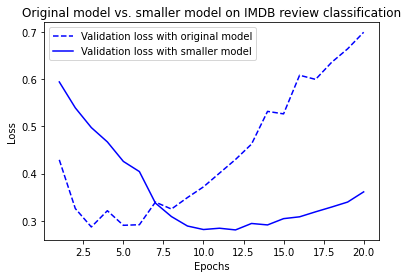

In [ ]:
import matplotlib.pyplot as plt

val_loss = history_original.history["val_loss"]
val_loss_smaller = history_smaller_model.history["val_loss"]
epochs = range(1, 21)  #x轴

plt.plot(epochs, val_loss, "b--",
         label="Validation loss with original model")
plt.plot(epochs, val_loss_smaller, "b-",
         label="Validation loss with smaller model")

plt.title("Original model vs. smaller model on IMDB review classification")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

更小的模型优化能力弱,在第 7~8 轮才到过拟合,原始模型到 5 轮就过拟合了.而且过拟合后,较少模型泛化性能下降也更慢.


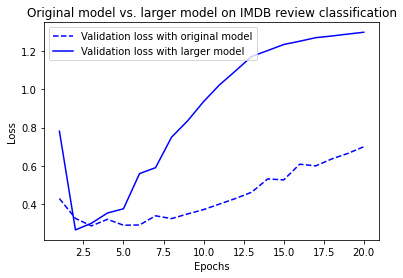

In [ ]:
val_loss = history_original.history["val_loss"]
val_loss_history = history_larger_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--", label="Validation loss with original model")
plt.plot(epochs,
         val_loss_history,
         "b-",
         label="Validation loss with larger model")

plt.title("Original model vs. larger model on IMDB review classification")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

更大的模型结果不用说了,刚开始就过拟合了,之后泛化能力急剧下降.最后在训练集上准确度都到 1 了...


### 权重正则化

假设某种事情有两种解释,那么最正确的往往是较为简单的那个. --> 奥卡姆剃刀.(干脆一切都是一场 Game 得了,~~吐槽~~)

对应到神经网络,就是越简单的模型越不容易拟合,也越不容易过拟合...(~~这是废话吗~~)

这一节的权重正则化,就是给模型参数调整时增加成本,使得模型会偏好选择较小的权重.方法是给损失函数添加成本,参数调整越大,成本越高.(俗称绑沙袋,小步走还能走,大步跑得累死).有两种~~沙袋~~成本.

- L1: 增加的成本与权重系数绝对值成正比.(线性)
- L2: 增加的都是与权重系数绝对值的平方成正比.(非线性),神经网络 L2 正则化也叫权重衰减,两者等价.


In [ ]:
from tensorflow.keras import regularizers

model = keras.Sequential([
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_l2_reg = model.fit(train_data,
                           train_labels,
                           epochs=20,
                           batch_size=512,
                           validation_split=0.4)


Epoch 1/20
30/30 [==============================] - 1s 21ms/step - loss: 0.5301 - accuracy: 0.7745 - val_loss: 0.3993 - val_accuracy: 0.8568
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.3186 - accuracy: 0.8998 - val_loss: 0.3062 - val_accuracy: 0.8909
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: 0.2301 - accuracy: 0.9252 - val_loss: 0.2884 - val_accuracy: 0.8866
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1793 - accuracy: 0.9430 - val_loss: 0.3037 - val_accuracy: 0.8781
Epoch 5/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1458 - accuracy: 0.9536 - val_loss: 0.2795 - val_accuracy: 0.8892
Epoch 6/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1201 - accuracy: 0.9646 - val_loss: 0.2908 - val_accuracy: 0.8875
Epoch 7/20
30/30 [==============================] - 0s 17ms/step - loss: 0.1005 - accuracy: 0.9691 - val_loss: 0.3062 - val_accuracy: 0.8854
Epoch 8/20
30

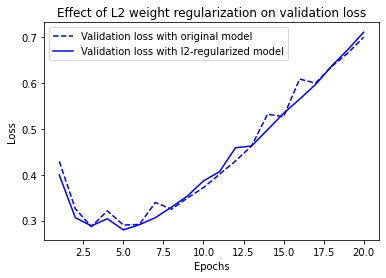

In [ ]:
val_loss = history_original.history["val_loss"]
val_loss_l2 = history_l2_reg.history["val_loss"]
epochs = range(1, 21)

plt.plot(epochs, val_loss, "b--", label="Validation loss with original model")
plt.plot(epochs,
         val_loss_l2,
         "b-",
         label="Validation loss with l2-regularized model")

plt.title("Effect of L2 weight regularization on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

似乎和说好的不一样啊..

总而言之,权重正则化如下

- `regularizers.l2(0.002)` L2 正则 权重绝对值^2 * 0.002.
- `regularizers.l1(0.001)` L1 正则 权重绝对值 * 0.001.
- `regularizers.l1_l2(l1=0.001, l2=0.001)` L1 L2 同时.


## dropout (drop it!)

dropout 是多伦多大学 Geoffrey  Hinton和他的学生开发神经网络正则化方法.

直观上是对某一层 dropout 就是将这一层的输出,按照一定比例(通常 0.2~0.5)丢弃归 0.但是测试时这些单元没有舍弃,这一层的输出值要按照 dropout 比例缩小,以平衡模型的容量.

其思想是随机失活,引入层与层之间的噪声,避免神经网络几个层一块记住训练集某些特征,而影响模型泛化能力.

keras 中引入 dropout 尤为简单,层之间添加 `layers.Dropout(0.5)`..


In [13]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_dropout = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 1s 26ms/step - loss: 0.6353 - accuracy: 0.6259 - val_loss: 0.5452 - val_accuracy: 0.8364
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.5229 - accuracy: 0.7568 - val_loss: 0.4337 - val_accuracy: 0.8720
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.4359 - accuracy: 0.8189 - val_loss: 0.3570 - val_accuracy: 0.8809
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3752 - accuracy: 0.8568 - val_loss: 0.3157 - val_accuracy: 0.8796
Epoch 5/20
30/30 [==============================] - 1s 17ms/step - loss: 0.3247 - accuracy: 0.8801 - val_loss: 0.2856 - val_accuracy: 0.8904
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2806 - accuracy: 0.9025 - val_loss: 0.2795 - val_accuracy: 0.8895
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2472 - accuracy: 0.9177 - val_loss: 0.2844 - val_accuracy: 0.8911
Epoch 8/20
30

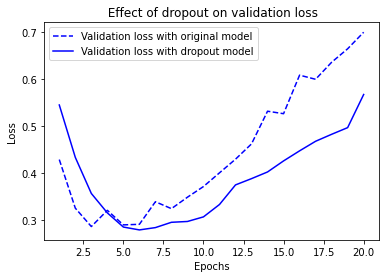

In [14]:
val_loss = history_original.history["val_loss"]
val_loss_dropout = history_dropout.history["val_loss"]
epochs = range(1, 21)

plt.plot(epochs, val_loss, "b--", label="Validation loss with original model")
plt.plot(epochs,
         val_loss_dropout,
         "b-",
         label="Validation loss with dropout model")

plt.title(" Effect of dropout on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

效果还不错.


最后简而言之,要 MAX 模型泛化

- 更多的数据
- 更好的特征
- 减小网络容量
- 权重的正则化
- 使用 dropout
